# Машинное обучение 1, ПМИ ФКН ВШЭ
# Семинар 7
# Тензоры, MLP

Всем привет! Сегодня мы обсудим введение в DL.

Перед тем, как начать семинар, давайте вкратце обсудим, на каких устройствах и почему мы считаем наши вычисления нейронных сетей.




1. **GPU** (графические процессоры) — основная рабочая лошадка современного машинного обучения. GPU содержат тысячи простых ядер, идеально подходящих для параллельных матричных операций, составляющих основу нейросетевых вычислений. Важно выделить два главных конкурента на рынке:

    1.1. **CUDA** NVIDIA доминирует в этой сфере с линейкой A100, H100, RTX 4090. Архитектуры Hopper и Ada Lovelace обеспечивают до 989 TOPS для ИИ-вычислений. Платформа CUDA имеет зрелую экосистему библиотек (cuDNN, cuBLAS), широкую поддержку фреймворков и оптимизированные драйверы, что делает NVIDIA стандартом индустрии (90% всех вычислений на видеокарточках NVIDIA) [1](https://developer.nvidia.com/cuda-toolkit), [2](https://github.com/NVIDIA/CUDALibrarySamples), [3](https://en.wikipedia.org/wiki/CUDA).

    1.2. **ROCm** AMD предлагает открытую альтернативу CUDA с картами MI300X, RX 7900 XTX. Поддерживает PyTorch, TensorFlow и JAX через HIP API. Преимущества: открытый исходный код, конкурентная цена, поддержка Linux. Но пока что меньшая экосистема библиотек, ограниченная совместимость с некоторыми фреймворками, много багов [1](https://www.amd.com/en/products/software/rocm.html), [2](https://github.com/ROCm/ROCm), [3](https://en.wikipedia.org/wiki/ROCm).

2. **TPU** от Google — тензорные процессоры, специально разработанные для нейросетевых вычислений. TPU v5 обеспечивает до 459 TOPS при энергопотреблении 200W. Оптимизированы для матричных операций, поддерживают bfloat16, интегрированы с TensorFlow/JAX. Доступны только через Google Cloud/Colab и работают в полную силу только на JAX [1](https://en.wikipedia.org/wiki/Tensor_Processing_Unit), [2](https://cloud.google.com/tpu).

3. **NPU** Huawei Ascend — китайская альтернатива западным решениям (+5 социального рейтинга от партии). Ascend 910B предлагает до 256 TOPS FP16, поддерживает MindSpore фреймворк. Особенности: собственная архитектура Da Vinci, оптимизация для китайского рынка, интеграция с облачными сервисами Huawei Cloud. Минусы такие же, как и у ROCm **AMD** [1](https://www.hiascend.com/en/), [2](https://gitee.com/ascend/pytorch).

4. **Metal** чипы от Apple (M-серия) — интегрированные процессоры с унифицированной памятью. Преимущества: энергоэффективность, бесшовная интеграция с macOS, оптимизированные Metal Performance Shaders. Поддержка CoreML, TensorFlow Lite. Ограничения: только экосистема Apple, возможно только что-то локальное запускать на инференс, обучать что-то серьезное не получится [1](https://developer.apple.com/metal/), [2](https://developer.apple.com/metal/pytorch/).
5. **CPU** используются для менее требовательных задач и вывода небольших моделей, но значительно медленнее GPU для обучения.

Почему считаем на видеокарточках? Нейросети требуют:

- Массовых параллельных вычислений (миллионы параметров обновляются одновременно).

- Интенсивных матричных операций (тензорные умножения, свертки).

- Оптимизированных операций с плавающей точкой.

Чтобы понять преимущество, посмотрите это [видео](https://www.youtube.com/watch?v=Ge-g3xZ5bb8).



Вы видели упоминание всяких FP16/BF16, операций с плавающией точкой и так далее, об этом поговорим чуть позже.

Давайте вкратце сначала обсудим про основные фреймворки в DL: `TensorFlow`, `JAX`, `Keras` и `Pytorch`.

## Фреймворки в DL

### TensorFlow


[TensorFlow](https://www.tensorflow.org) - один из самых известных фреймворков глубокого обучения, созданный Google Brain в 2015 году. Изначально он строился вокруг статических вычислительных графов, что позволяло эффективно оптимизировать и компилировать вычисления для масштабного обучения, особенно на GPU и TPU. Такая архитектура была мощной, но вызывала у исследователей затруднения: приходилось заранее описывать граф, что делало отладку и эксперименты менее гибкими.


С течением времени TensorFlow прошел эволюцию. Появилось Eager Execution (динамический режим, аналогичный PyTorch), а также множество надстроек, включая Keras как основной высокоуровневый API. TensorFlow развивается не только как библиотека для обучения моделей, но и как экосистема для продакшна. Здесь выделяются:

- TensorFlow Serving - система для развертывания и обслуживания моделей.

- TensorFlow Lite - инструментарий для оптимизации и запуска моделей на мобильных устройствах и микроконтроллерах.

- TensorFlow.js - запуск моделей прямо в браузере.

Главное преимущество, что есть поддержка TPU и сразу из коробки есть возможность развернуть на слабых устройствах.

TensorFlow постепенно уступил позиции PyTorch.

Основные причины: более сложный интерфейс в ранних версиях, медленное внедрение динамических графов и менее “питонический” стиль кода.

### JAX

[JAX](https://github.com/jax-ml/jax) - относительно новый инструмент от Google Research, который позиционируется не столько как полноценный фреймворк для нейросетей, сколько как библиотека для ускоренных численных вычислений и автоматического дифференцирования. По сути, JAX объединяет возможности NumPy, автоматического дифференцирования (autograd) и компиляции XLA, что делает его мощным инструментом для научных исследований.

Основные идеи JAX заключаются в нескольких ключевых трансформациях:

`grad` - автоматическое вычисление градиентов.

`jit` - Just-In-Time компиляция, позволяющая ускорить выполнение кода за счёт оптимизации и компиляции под XLA.

`vmap` - векторизация, позволяющая автоматически параллелить вычисления по батчам данных.

`pmap` - распределённое выполнение на множестве устройств (GPU/TPU).

Важно, что JAX по философии ближе к функциональному программированию: в отличие от PyTorch и TensorFlow, которые живут по объектно-ориентированные паттернам, JAX требует работы с чистыми функциями и трансформациями.

Поверх JAX развилась экосистема:

1. [Flax](https://github.com/google/flax) - гибкая библиотека для нейросетей.

2. [Haiku](https://github.com/google-deepmind/dm-haiku) (DeepMind) - более модульный подход.

3. [Optax](https://github.com/google-deepmind/optax) - набор оптимизаторов.

4. [RLax](https://github.com/google-deepmind/rlax) - компоненты для обучения с подкреплением.

Преимущество JAX - очень высокая производительность и гибкость. Его можно ценить за возможность быстро экспериментировать со сложной математикой (например, PDE-решатели или физически-информированные нейросети) и при этом масштабироваться на TPU-кластеры.

Недостаток JAX - это ещё относительно «молодая» экосистема. Нет такого количества готовых моделей и обучающих материалов, как у PyTorch. Кроме того, JAX требует более глубокого понимания программирования и функционального подхода, что повышает порог вхождения.

### Keras

[Keras](https://keras.io/) - это высокоуровневый API для глубокого обучения, изначально разработанный как независимая библиотека известным ученым [Франсуа Шолле](https://scholar.google.com/citations?user=VfYhf2wAAAAJ&hl=en), но позже интегрированный в TensorFlow. Сегодня Keras 3 (выпущенный в 2023 – 2024 годах) поддерживает мультибэкенд: работать можно не только с TensorFlow, но и с PyTorch и JAX.
По факту - это оболочка над 3-я фреймворками.

Главная идея Keras - простота и читаемость [!важно]. Даже на главной странице написано:

> *Keras is a deep learning API designed for human beings, not machines.*



В то время как TensorFlow и PyTorch требуют описывать детали графа или слоя, Keras предоставляет декларативный и понятный стиль:` model = Sequential([Dense(...), Activation(...)])`.

Но естественно простота несет за собой более ограниченный контроль по сравнению с «чистыми» фреймворками. И из-за этого практически нигде не используется, кроме как фреймворк для обучения работы с DL.

### PyTorch

[PyTorch](https://pytorch.org/) появился в 2017 году в FAIR как «питоничный» наследник Torch7 (Lua). Он сделал ставку на динамические вычислительные графы и автодифференцирование, что резко упростило исследовательскую работу. Благодаря простоте, гибкости и тесной интеграции с экосистемой Python он быстро стал стандартом в академии и индустрии, вытеснив статические графы эпохи TensorFlow 1.x.

Почему он крут и популярен:

- Удобство: естественный Python-API, простая отладка, контроль потока (if/for).
- Производительность: CUDA, AMP, `torch.compile` (2.x), профилировщик.
- Масштаб: DDP/FSDP, поддержка огромных моделей.
- Экосистема: torchvision/torchaudio/torchtext и стал основой для Hugging Face.
- Продакшн: TorchServe, ONNX/TensorRT, C++ libtorch.
- Сообщество: тысячи туториалов, быстрый выпуск фич, удобство интегрирования свое.

Ключевые преимущества: динамический граф + удобство Python → быстрые исследования и надёжный продакшн.

### Сравнительная таблица

| Фреймворк      | Основная идея             | Сильные стороны                                   | Слабые стороны                           | Основные сферы применения |
|----------------|---------------------------|--------------------------------------------------|------------------------------------------|---------------------------|
| **TensorFlow** | Статический/динамический граф | Продакшн-инструменты, поддержка TPU, кросс-платформенность | Сложнее для исследований, менее питоничный | Поддержание старых решений, мобильные/веб-решения |
| **JAX**        | Функциональный стиль, XLA, автодиф | Высокая производительность, гибкость, TPU-кластеризация | Молодая экосистема, высокий порог входа   | Cutting-edge исследования, математика, физика |
| **Keras**      | Высокоуровневый API        | Простота, мультибэкенд, быстрые прототипы        | Ограниченный контроль, меньше гибкости   | Обучение, быстрый старт, учебные курсы |
| **PyTorch**    | Динамический граф          | Простота, гибкость, огромное сообщество, продакшн-инструменты | Ранее слабый деплой, но за счет сообщества щас все норм | Промышленный деплой, исследования, индустрия, курсы |


## Torch

### Установка PyTorch

In [ ]:
# !pip install torch

См. [здесь](https://pytorch.org/get-started/locally/), как установить PyTorch с поддержкой GPU для различных операционных систем.



### Активируем GPU (если в колабе)

По шагам:

1. Нажимаем "Среда выполнения" (сверху на панели).
2. Нажимаем "Сменить среду выполнения".
3. Выбираем Графический процессор T4.

In [ ]:
!nvidia-smi

Sat Aug 23 14:16:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Проверяем, что все работает

In [ ]:
import torch
print("Версия torch:", torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Устройство:", device)

Версия torch: 2.8.0+cu126
Устройство: cuda


### Вспомогательные функции

In [ ]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import numpy as np
import time
torch.manual_seed(0)

In [ ]:
def plot_live(epoch, model, x_train, y_train, x_val, y_val, x_all, y_true_all,
              train_losses, val_losses):
    clear_output(wait=True)

    # Лоссы
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="train MSE")
    plt.plot(val_losses, label="val MSE")
    plt.xlabel("epoch"); plt.ylabel("loss (MSE)")
    plt.title(f"Learning curves (epoch {epoch})")
    plt.legend(); plt.grid(True)
    display(plt.gcf())
    plt.close()

    # Предсказания
    model.eval()
    with torch.no_grad():
        y_pred_all = model(x_all).cpu().numpy()
    x_cpu = x_all.cpu().numpy()
    y_true_cpu = y_true_all.cpu().numpy()

    order = np.argsort(x_cpu[:,0])

    plt.figure(figsize=(7,4))
    plt.scatter(x_train.cpu().numpy(), y_train.cpu().numpy(), s=10, alpha=0.35, label="train noisy")
    plt.scatter(x_val.cpu().numpy(), y_val.cpu().numpy(), s=10, alpha=0.35, label="val noisy")
    plt.plot(x_cpu[order], y_true_cpu[order], linewidth=2, label="true sin(x)")
    plt.plot(x_cpu[order], y_pred_all[order], linewidth=2, label=f"prediction @ {epoch}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title("Model prediction vs ground truth")
    plt.legend(); plt.grid(True)
    display(plt.gcf())
    plt.close()

In [ ]:
def rosenbrock(w, a=1.0, b=100.0):
    x, y = w[0], w[1]
    return (a - x)**2 + b*(y - x**2)**2


def make_optimizer(params, name: str, **kwargs):
    name = name.lower()
    if name == "sgd":
        return torch.optim.SGD(params,
            lr=kwargs.get("lr", 5e-4),
            momentum=kwargs.get("momentum", 0.9),
            weight_decay=kwargs.get("weight_decay", 0.0),
            nesterov=kwargs.get("nesterov", False))
    if name == "adam":
        return torch.optim.Adam(params,
            lr=kwargs.get("lr", 2e-3),
            betas=kwargs.get("betas", (0.9, 0.999)),
            eps=kwargs.get("eps", 1e-8),
            weight_decay=kwargs.get("weight_decay", 0.0))
    if name == "lbfgs":
        return torch.optim.LBFGS(params,
            lr=kwargs.get("lr", 1.0),
            max_iter=kwargs.get("max_iter", 10),
            history_size=kwargs.get("history_size", 10),
            line_search_fn=kwargs.get("line_search_fn", "strong_wolfe"))
    raise ValueError(f"Unknown optimizer: {name}")


def plot_live_optim(step, path, losses, grad_norms, xx, yy, zz, title):
    clear_output(wait=True)

    plt.figure(figsize=(6,5))
    plt.contour(xx, yy, zz, levels=25)
    P = np.array(path)
    if len(P) > 1:
        plt.plot(P[:,0], P[:,1], marker="o", markersize=2, linewidth=1)
    plt.title(f"{title} — step {step}")
    plt.xlabel("x"); plt.ylabel("y")
    display(plt.gcf()); plt.close()

    plt.figure(figsize=(7,3.5))
    plt.plot(losses, label="loss")
    plt.plot(grad_norms, label="||grad||")
    plt.xlabel("step"); plt.title("Loss & gradient norm")
    plt.legend(); plt.grid(True)
    display(plt.gcf()); plt.close()


def run_live_optim(opt_name="sgd", steps=300, plot_every=10, start=(-1.5, 2.0), **opt_kwargs):
    x_min,x_max,y_min,y_max = -2.0,2.0,-1.0,3.0
    xx,yy = np.meshgrid(np.linspace(x_min,x_max,180), np.linspace(y_min,y_max,180))
    zz = (1-xx)**2 + 100.0*(yy-xx**2)**2

    w = torch.tensor(start, dtype=torch.float32, requires_grad=True)
    opt = make_optimizer([w], opt_name, **opt_kwargs)
    path, losses, grad_norms = [], [], []

    def closure():
        opt.zero_grad(); loss = rosenbrock(w); loss.backward(); return loss

    for t in range(1, steps+1):
        if opt_name.lower() == "lbfgs":
            loss = opt.step(closure)
            loss_val = loss.item() if hasattr(loss, "item") else float(loss)
        else:
            opt.zero_grad(); loss = rosenbrock(w); loss.backward(); opt.step()
            loss_val = float(loss.detach())

        with torch.no_grad():
            gnorm = float(w.grad.norm()) if w.grad is not None else float("nan")
        path.append(w.detach().numpy().copy())
        losses.append(loss_val); grad_norms.append(gnorm)

        if t % plot_every == 0 or t == 1 or t == steps:
            plot_live(t, path, losses, grad_norms, xx, yy, zz, f"{opt_name.upper()} on Rosenbrock")

    return np.array(path), np.array(losses), np.array(grad_norms), w.detach().numpy()

## Основные объекты в PyTorch

Познакомимся с основными объектами в PyTorch:

- **Тензоры (torch.Tensor)**: многомерные массивы с dtype/device, могут хранить градиенты (requires_grad=True).


- **Автодифференцирование (autograd)**: автоматически строит вычислительный граф и считает градиенты.

- **Модули (torch.nn.Module)**: слои и модели; обучаемые веса — это nn.Parameter.

- **Оптимизаторы (torch.optim)**: SGD, Adam и др.; получают параметры модели и обновляют их через step()/zero_grad().

- **torch.nn**: например, Dropout, MSELoss — блоки PyTorch.

- **Данные**: Dataset, DataLoader (параллельная загрузка, батчи), Sampler; трансформации/аугментации (часто из torchvision.transforms).

- **Полезные режимы/утилиты**: model.train()/eval(), torch.no_grad(), функциональный API torch.nn.functional, управление устройством (cpu/cuda).

## Тензоры

## Что такое `torch.Tensor`?

<img src="https://drive.google.com/uc?export=view&id=1Ona80D87Z_bR5GsCIZUk_JxFIdvF4s6M" alt="Тензор_мем" width="600"/>

В библиотеке PyTorch базовым строительным блоком является объект тензор - [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html).

> Тензор в PyTorch - это многомерный массив, очень похожий на NumPy array, но с дополнительными возможностями:

- поддержка вычислений на GPU (CUDA, ROCm, Metal),
- автоматическое дифференцирование (через autograd),
- интеграция в глубокие нейронные сети и оптимизационные задачи.

Если упростить:

- **скаляр** - число (тензор нулевой размерности),
- **вектор** - одномерный массив (тензор размерности 1),
- **матрица** - двумерный массив (тензор размерности 2),
- **тензор** - обобщение на $n$ измерений.

### Создание тензоров

Тензоры можно создавать разными способами:

Из Python-списка или массива (вектор)

In [ ]:
print(torch.Tensor([1, 2, 3, 4.5])) # 1D вектор
print(torch.Tensor([[1, 2, 3], [4, 5, 6]])) # 2D матрица

tensor([1.0000, 2.0000, 3.0000, 4.5000])
tensor([[1., 2., 3.],
        [4., 5., 6.]])


Создать матрицу из NumPy массива:

In [ ]:
import numpy as np

np_array = np.array([[1, 2, 3], [4, 5, 6]])
torch_tensor = torch.from_numpy(np_array)
print(torch_tensor)


tensor([[1, 2, 3],
        [4, 5, 6]])


Создать случайную матрицу:

In [ ]:
print(f"Равномерное распределение [0, 1):\n {torch.rand(2, 3)}")
print(f"Нормальное распределение:\n {torch.randn(2, 3)}")

Равномерное распределение [0, 1):
 tensor([[0.8367, 0.7031, 0.8978],
        [0.7610, 0.4793, 0.7967]])
Нормальное распределение:
 tensor([[ 0.5356,  0.4066, -0.2959],
        [-0.1224, -0.5415,  1.0334]])


Создать специальный тензор:

In [ ]:
print(f"Матрица из нулей:\n {torch.zeros(3, 3)}")
print(f"Матрица из единиц:\n {torch.ones(2, 2)}")
print(f"Единичная матрица:\n {torch.eye(4)}")
print(f"Тензор чисел от 0 до 9 включительно:\n {torch.arange(0, 10, 2)}")
print(f"Тензор чисел от 0 до 1 с шагом 0.25:\n {torch.linspace(0, 1, 5)}")  # [0., 0.25, 0.5, 0.75, 1.]

Матрица из нулей:
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])
Матрица из единиц:
 tensor([[1., 1.],
        [1., 1.]])
Единичная матрица:
 tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Тензор чисел от 0 до 9 включительно:
 tensor([0, 2, 4, 6, 8])
Тензор чисел от 0 до 1 с шагом 0.25:
 tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])


### Атрибуты тензоров

In [ ]:
x = torch.Tensor([[1, 2, 3], [4, 5, 6]])

print(f"{x.shape} → форма aka шейп ака размерность")
print(f"{x.ndim} → количество измерений")
print(f"{x.size(0)} → размер по оси 0")
print(f"{x.size(1)} → размер по оси 1")
print(f"{x.dtype} → тип данных тензора")
print(f"{x.device} → устройство, где лежит тензор")
print(f"{x.requires_grad} → требует градиент")


torch.Size([2, 3]) → форма aka шейп ака размерность
2 → количество измерений
2 → размер по оси 0
3 → размер по оси 1
torch.float32 → тип данных тензора
cpu → устройство, где лежит тензор
False → требует градиент


### Типы данных (`dtype`)

Тип данных - это формальное описание того, какие значения может хранить переменная и какие операции над ней допустимы. Типы данных позволяют компьютеру корректно интерпретировать двоичное представление информации. Например, набор бит 01000001 может означать число 65 в десятичной системе, а может обозначать символ 'A' в кодировке ASCII.

Таким образом, `dtype` определяет:

1. Вид значения — целое, вещественное, булево и т.п.

2. Разрядность (8, 16, 32, 64 бит), которая влияет на диапазон возможных значений, точность и объём памяти.

PyTorch [поддерживает разные типы данных](https://docs.pytorch.org/docs/stable/tensors.html):

<!-- - **Целые числа:**  
  `torch.int8`, `torch.int16`, `torch.int32`, `torch.int64`

- **Вещественные числа:**  
  `torch.float16`, `torch.float32`, `torch.float64`

- **Булевы:**  
  `torch.bool`

- **Комплексные:**  
  `torch.complex64`, `torch.complex128`

**По умолчанию:**
- для целых — `torch.int64`
- для вещественных — `torch.float32` -->

| dtype                      | Диапазон значений                                  | Где применяется                                                         |
| -------------------------- | -------------------------------------------------- | ----------------------------------------------------------------------- |
| **torch.uint8**            | 0 … 255                                            | Маски, изображения в формате byte (0–255 пиксели)                       |
| **torch.int8**             | –128 … 127                                         | Квантованные модели, экономия памяти                                    |
| **torch.int16**            | –32 768 … 32 767                                   | Редко используется, промежуточный тип                                   |
| **torch.int32**            | –2 147 483 648 … 2 147 483 647                     | Индексы, работа с табличными данными                                    |
| **torch.int64**            | –9.22e18 … 9.22e18                                 | Индексы тензоров, метки классов (стандарт в PyTorch)                    |
| **torch.float16 (Half)**   | \~ ±6.5e4, точность \~3 знака                      | Обучение на GPU (Mixed Precision), ускорение вычислений                 |
| **torch.bfloat16**         | \~ ±3.4e38, точность \~3 знака (короткая мантисса) | Обучение на современных GPU/TPU, баланс между скоростью и стабильностью |
| **torch.float32 (Float)**  | \~ ±3.4e38, точность \~7 знаков                    | Основной тип для обучения нейросетей (default)                          |
| **torch.float64 (Double)** | \~ ±1.8e308, точность \~15 знаков                  | Научные вычисления, когда нужна высокая точность                        |
| **torch.bool**             | True / False                                       | Логические маски, фильтрация элементов                                  |
| **torch.complex64**        | Два float32 (вещественная + мнимая часть)          | Сигнальная обработка, квантовая физика                                  |
| **torch.complex128**       | Два float64                                        | Высокоточные комплексные вычисления                                     |

---


![Чиселки](https://sungminlee0810.github.io/assets/images/2021_0224/image1.png)

Мы не всегда используем `float16`, потому что этот формат слишком ограничен по диапазону и точности, что часто делает обучение нейросетей нестабильным.  

- В реальных вычислениях (например, при экспоненте в softmax) встречаются гораздо большие числа. Это приводит к **переполнению (overflow)**, когда значения превращаются в `inf`, или наоборот - к **обнулению (underflow)** для очень маленьких чисел.  
- Градиенты в обучении часто бывают очень малыми $(10^{-6}$, $10^{-8})$, и в `float16` они просто исчезают, становясь нулями.  

Поэтому `float16` применяют в основном в режиме **mixed precision** (смешанная точность): часть операций и веса в `float16`, но накопление градиентов и критические вычисления остаются в `float32`. Это позволяет использовать преимущества FP16 (меньше памяти и быстрее на GPU с Tensor Cores) без потери стабильности.  

---

Мы практически никогда не используем **float64** (double precision), потому что:  

- он требует **в 2 раза больше памяти**,  
- выполняется значительно медленнее на GPU (многие ускорители сильно ограничены по FP64-производительности),  
- в 99% задач машинного обучения такой точности просто не требуется.  
- [в 1% задач](https://arxiv.org/html/2505.10949v1).  

---

В итоге, **основной рабочий формат в нейросетях - `float32` (`FP32`)**.  

- `FP32` - это "золотой стандарт": именно в нём PyTorch по умолчанию создает тензоры и обучает модели.  Он обеспечивает баланс между скоростью, точностью и стабильностью.


In [ ]:
a = torch.tensor([1, 2, 3], dtype=torch.int32)
b = torch.tensor([1.0, 2.0, 3.0], dtype=torch.float32)

print(a.dtype)  # torch.int32
print(b.dtype)  # torch.float32

#

torch.int32
torch.float32


> **Важно!**, чтобы все данные имели один и тот же тип, иначе это может привести к неожиданным ошибкам.

### Преобразования тензоров

In [ ]:
A = torch.rand(2, 6)
print(A)

tensor([[0.8511, 0.0219, 0.4809, 0.6897, 0.0225, 0.8915],
        [0.3319, 0.2647, 0.4621, 0.1449, 0.7370, 0.3102]])


Превратить тензор в одномерный массив:

In [ ]:
print(A.flatten())
print(A.reshape(-1))

tensor([0.8511, 0.0219, 0.4809, 0.6897, 0.0225, 0.8915, 0.3319, 0.2647, 0.4621,
        0.1449, 0.7370, 0.3102])
tensor([0.8511, 0.0219, 0.4809, 0.6897, 0.0225, 0.8915, 0.3319, 0.2647, 0.4621,
        0.1449, 0.7370, 0.3102])


Транспонировать матрицу:

In [ ]:
print(A.T)

tensor([[0.8511, 0.3319],
        [0.0219, 0.2647],
        [0.4809, 0.4621],
        [0.6897, 0.1449],
        [0.0225, 0.7370],
        [0.8915, 0.3102]])


Для тензоров более высокой размерности нужно указать, какие измерения переставить.

In [ ]:
print(A.transpose(0, 1))

tensor([[0.8511, 0.3319],
        [0.0219, 0.2647],
        [0.4809, 0.4621],
        [0.6897, 0.1449],
        [0.0225, 0.7370],
        [0.8915, 0.3102]])


#### **Важно!**

Допустим, у нас есть батч изображений в формате **NCHW** (batch, height, width, channels), как часто бывает при загрузке из NumPy/PIL:

In [ ]:
# batch=32, высота=64, ширина=64, каналов=3
x = torch.randn(32, 64, 64, 3)
print(x.shape)  # torch.Size([32, 64, 64, 3])

torch.Size([32, 64, 64, 3])


PyTorch Conv2d ожидает данные в формате **NCHW** (batch, channels, height, width).

Здесь нельзя просто сделать `reshape(32, 3, 64, 64)`, потому что это перепутает данные: каналы не переместятся на нужную ось, а просто "нарежутся" из памяти.

Правильный способ:

In [ ]:
x = x.permute(0, 3, 1, 2)  # (batch, channels, height, width)
print(x.shape)


torch.Size([32, 3, 64, 64])


Давайте взглянем более подробно:

In [ ]:
a = torch.arange(12).reshape(3, 4)  # (3,4)
print(f"{a} \n")

# Хочется поменять местами оси: (4,3)
b = a.permute(1, 0)
print(f"{b} \n")


# Но если использовать reshape:
c = a.reshape(4, 3)
print(c)

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]]) 

tensor([[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]]) 

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])


Видно, что `reshape` не меняет оси, а просто "перекладывает" данные подряд.

А `permute` именно транспонирует.

Когда использовать `permute` и `reshape` в PyTorch.

| Задача | Пример входных данных | Что хотим | Правильный метод | Почему |
|--------|----------------------|-----------|------------------|--------|
| **Поменять порядок осей (транспонирование)** | `a.shape = (3, 4)` | `→ (4, 3)` | `a.permute(1, 0)` | Нужна перестановка измерений, `reshape` перепутает данные |
| **Изображения: NHWC → NCHW** | `(32, 64, 64, 3)` | `→ (32, 3, 64, 64)` | `x.permute(0, 3, 1, 2)` | `Conv2d` в PyTorch ждёт `(batch, channels, H, W)` |
| **Временные ряды: (batch, time, features) → (time, batch, features)** | `(16, 50, 128)` | `→ (50, 16, 128)` | `x.permute(1, 0, 2)` | `RNN/Transformer` часто требуют другой порядок |
| **Просто "сплющить" данные (flatten)** | `(32, 3, 64, 64)` | `→ (32, 12288)` | `x.reshape(32, -1)` | Оси не меняем, просто склеиваем |
| **Добавить размерность** | `(32, 128)` | `→ (32, 128, 1)` | `x.reshape(32, 128, 1)` | Новый размер без перестановки |
| **Разделить измерение на несколько** | `(32, 12288)` | `→ (32, 3, 64, 64)` | `x.reshape(32, 3, 64, 64)` | Данные уже в правильном порядке, надо только "распаковать" |
| **Транспонирование матриц в batch’е** | `(batch, M, N)` | `→ (batch, N, M)` | `x.permute(0, 2, 1)` | Транспонируем только последние две оси |

---
Правило здесь следующее:
- **`permute`** - когда меняем **оси** (их порядок).  
- **`reshape`** - когда меняем **форму** (размерности внутри осей), но их порядок остаётся.  


### Операции с тензорами одинаковой размерности

In [ ]:
a = torch.Tensor([1, 2, 3]) # 1D вектор
b = torch.Tensor([-1, 0, 1]) # 1D вектор

A = torch.Tensor([[ 0, 1, 2], # 2D матрица
                  [-1, 0, 1]])
B = torch.Tensor([[1, 2, 3], # 2D матрица
                  [7, 0, 5]])
print(a)
print(b)
print(A)
print(B)

tensor([1., 2., 3.])
tensor([-1.,  0.,  1.])
tensor([[ 0.,  1.,  2.],
        [-1.,  0.,  1.]])
tensor([[1., 2., 3.],
        [7., 0., 5.]])


Покомпонентное сложение:

In [ ]:
print("В случае 1D вектора:")
print(a + b) # 1D вектор
print("В случае 2D матрицы:")
print(A + B) # 2D матрица

В случае 1D вектора:
tensor([0., 2., 4.])
В случае 2D матрицы:
tensor([[1., 3., 5.],
        [6., 0., 6.]])


Покомпонентное умножение:

In [ ]:
print("В случае 1D вектора:")
print(a * b) # 1D вектор

print("В случае 2D матрицы:")
print(A * B) # 2D матрица

В случае 1D вектора:
tensor([-1.,  0.,  3.])
В случае 2D матрицы:
tensor([[ 0.,  2.,  6.],
        [-7.,  0.,  5.]])


Покомпонентное возведение в степень:

In [ ]:
print("В случае 1D вектора:")
print(a**b) # 1D вектор

print("В случае 2D матрицы:")
print(A ** B) # 2D матрица

В случае 1D вектора:
tensor([1., 1., 3.])
В случае 2D матрицы:
tensor([[ 0.,  1.,  8.],
        [-1.,  1.,  1.]])


Скалярное произведение:

In [ ]:
print(a @ b)
print(a * b)

tensor(2.)
tensor([-1.,  0.,  3.])


Умножение матрицы на вектор:

In [ ]:
print(A @ a)

tensor([8., 2.])


#### **Важно не забыть:**

Подводный камень: `a == b` дает булев тензор, а не скаляр. Для проверки эквивалентности используем `torch.equal(a, b)`.

In [ ]:
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([1.0, 2.0, 3.0])

print(a == b)
print((a == b).all())
print(a is b)

tensor([True, True, True])
tensor(True)
False


In [ ]:
a = torch.ones(3, 3, device="cpu")
b = torch.ones(3, 3, device="cuda")

print(a + b)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

Нужно явно приводить: `b.to("cpu")` или `a.to("cuda")`.

> Важно, чтобы все вычисления проводились только на выбранном девайсе.

### Операции с тензорами разной размерности

In [ ]:
A = torch.Tensor([[1, 2, 3], # 2D матрица
                  [4, 5, 6]])
v_row = torch.Tensor([0, 1, 2]) # 1D вектор
v_col = torch.Tensor([[0], [1]]) # 2D матрица
print(A) # 2D матрица
print(v_row) # 1D вектор
print(v_col) # 2D матрица

tensor([[1., 2., 3.],
        [4., 5., 6.]])
tensor([0., 1., 2.])
tensor([[0.],
        [1.]])


Прибавить к каждой строке матрицы один и тот же вектор:

In [ ]:
print(A + v_row)

tensor([[1., 3., 5.],
        [4., 6., 8.]])


Прибавить к каждому столбцу матрицы один и тот же вектор:

In [ ]:
print(A + v_col)

tensor([[1., 2., 3.],
        [5., 6., 7.]])


#### **Важно учесть:**

In [ ]:
a = torch.ones(3).unsqueeze(-1) # 2D матрица
b = torch.ones(3) # 1D вектор

print((a + b).shape) # torch.Size([3, 3]) — broadcasting, не [3,1]

torch.Size([3, 3])


При одинаковой "длине" по одной оси PyTorch включает broadcasting, создавая тензор большего размера.

Это частные случаи [broadcasting](https://pytorch.org/docs/stable/notes/broadcasting.html) - механизма PyTorch (и NumPy/JaX), позволяющий автоматически расширять размеры тензоров для поэлементных операций без явного копирования данных.

Посмотреть все операции можно в официальной [документации](https://pytorch.org/docs/stable/torch.html).

## Автоматическое дифференцирование

<img src="https://drive.google.com/uc?export=view&id=1Q9tL9j3I2wOIZ5rfHV_nIA7GwrqwwUI-" alt="Автодиф" width="1000">

Автоматическое дифференцирование - это способ точно вычислять производные программ (не только формул) за время, сравнимое с временем прямого расчёта. Важно отличать его от:

1. численного дифференцирования (конечные разности и конечных элементов) - просто приближает производные и чувствительно к шагу/шуму;

2. символьного (как в CAS) - оперирует формулами, но плохо справляется с произвольным кодом (циклы, ветвления, таблицы).

Идея автодифа: представить вычисление как граф из примитивных операций (сложение, умножение, sin, exp, matmul), для каждой операции знать локальные производные и собрать глобальные градиенты по [Chain Rule](https://en.wikipedia.org/wiki/Chain_rule).

Перед тем, как считать производную,

In [ ]:
x = torch.Tensor([-1.0, 3.0, -3.0]).requires_grad_(True)
c = torch.Tensor([0.0, 1.0, 2.0])
L = torch.sum((x - c)**2)
print(x)
print(c)
print(L)

tensor([-1.,  3., -3.], requires_grad=True)
tensor([0., 1., 2.])
tensor(30., grad_fn=<SumBackward0>)


Считаем градиент переменной `L` по параметрам `x`:

In [ ]:
L.backward()

Градиент по `x`:

In [ ]:
print(x.grad)

tensor([ -2.,   4., -10.])


Минимизируем `L` методом [градиентного спуска](https://en.wikipedia.org/wiki/Gradient_descent):

In [ ]:
optimizer = torch.optim.SGD(params=[x], lr=0.1)

for _ in range(100):
    optimizer.zero_grad()
    L = torch.sum((x - c)**2)
    L.backward()
    optimizer.step()

L = torch.sum((x - c)**2)

print(L, x)

tensor(1.1369e-13, grad_fn=<SumBackward0>) tensor([-2.0370e-10,  1.0000e+00,  2.0000e+00], requires_grad=True)


## `torch.nn`

`torch.nn` - это один из столпов PyTorch, предназначенный для построения и обучения нейронных сетей.

Он предоставляет слои, функции активации, лоссы и утилиты, которые упрощают создание моделей нейронок.

Главная цель - сделать код нейросетей модульным, удобным, ✨aestetic✨ и читаемым.

In [ ]:
import torch.nn as nn

### Линейный слой:

Линейный слой (linear layer, dense layer, fully connected layer) - это базовый элемент нейронных сетей.  

Он выполняет *аффинное преобразование* входного вектора, то есть линейный слой берёт комбинацию входных признаков, масштабирует и сдвигает их.

Это позволяет перевести исходные данные в другое пространство признаков.


*Формула*

Если на вход подаётся вектор признаков $x \in \mathbb{R}^n $, то линейный слой вычисляет:

$$
y = Wx + b
$$

где:

- $ W \in \mathbb{R}^{m \times n}$ — матрица весов  
- $ b \in \mathbb{R}^m $ — вектор смещений (*bias*)  
- $ y \in \mathbb{R}^m $ — выход  

In [ ]:
layer = nn.Linear(5, 3)
input_tensor = torch.randn(2, 5)
result = layer(input_tensor)
print(result)
print("Shape:", result.shape)

tensor([[-0.0279, -0.1297, -0.5944],
        [-0.1514,  0.2333, -0.4397]], grad_fn=<AddmmBackward0>)
Shape: torch.Size([2, 3])


#### Где используется

- **Классификация** (финальный логит-слой):  
  `nn.Linear(hidden, num_classes)`.

- **Регрессия / головы** в задачах детекции, сегментации.

- **Проекции в трансформерах**  
  (Q/K/V/Out — это линейные слои).

- **FeedForward Network (FFN)** в трансформерах.

- **Bottleneck’и** (сжатие/расширение размерности).

- **Эквивалент** `Conv2d(..., kernel_size=1)` при работе по каналам.

### Активации

Функции активации - это важный элемент нейронных сетей, позволяющий моделировать нелинейные зависимости.

Если бы мы использовали только линейные слои, например:

$$
y = Wx + b
$$

то сеть представляла бы собой одно линейное преобразование, независимо от числа слоёв. Именно активации делают возможным приближение сложных функций.

#### Базовые активации

**Sigmoid:**

$$
\sigma(x) = \frac{1}{1 + e^{-x}}
$$

Сжимает значения в диапазон $[0, 1]$. Исторически была популярна, но страдает от затухания градиента.  
Сейчас используется в **LSTM/GRU** для "врат" (решают, какие данные пропустить), а также в задачах **бинарной классификации** (например, логистическая регрессия).

---

**Tanh:**

$$
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

Диапазон $[-1, 1]$, центрированная версия sigmoid.  
До сих пор используется в **Physics-Informed Neural Networks (PINNs)** как основная активация (благодаря симметрии вокруг нуля), а также в рекуррентных сетях (LSTM/GRU). Минус — подвержена затуханию градиента.

---

**ReLU:**

$$
\mathrm{ReLU}(x) = \max(0, x)
$$

Простая и быстрая, решает проблему затухающих градиентов, но может "умирать" (dead ReLU).  
Самая распространённая активация в **свёрточных сетях (CNN)**, базовых **MLP** и даже во многих современных архитектурах (например, ResNet).  

---

**Softmax:**

$$
\mathrm{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}
$$

Преобразует вектор в распределение вероятностей: все значения лежат в диапазоне $[0,1]$, а сумма равна $1$.  
Используется на **выходном слое многоклассовых классификаторов** (NLP, CV, табличные модели) для получения вероятностей классов.  

---

**Leaky ReLU, GELU, Swish** - современные улучшенные варианты, обеспечивающие более плавный градиент.  
**Leaky ReLU** применяется в GAN (борьба с "мертвыми" нейронами).  
**GELU** - стандарт в **трансформерах** (BERT, GPT, Vision Transformer).  
**Swish** используется в **EfficientNet** и других современных архитектурах для улучшения точности при незначительном увеличении вычислений.



In [ ]:
layer = nn.ReLU()
print(layer(torch.tensor([[-1.0, 1.0, 2.0, 3.0, -5.0]])))

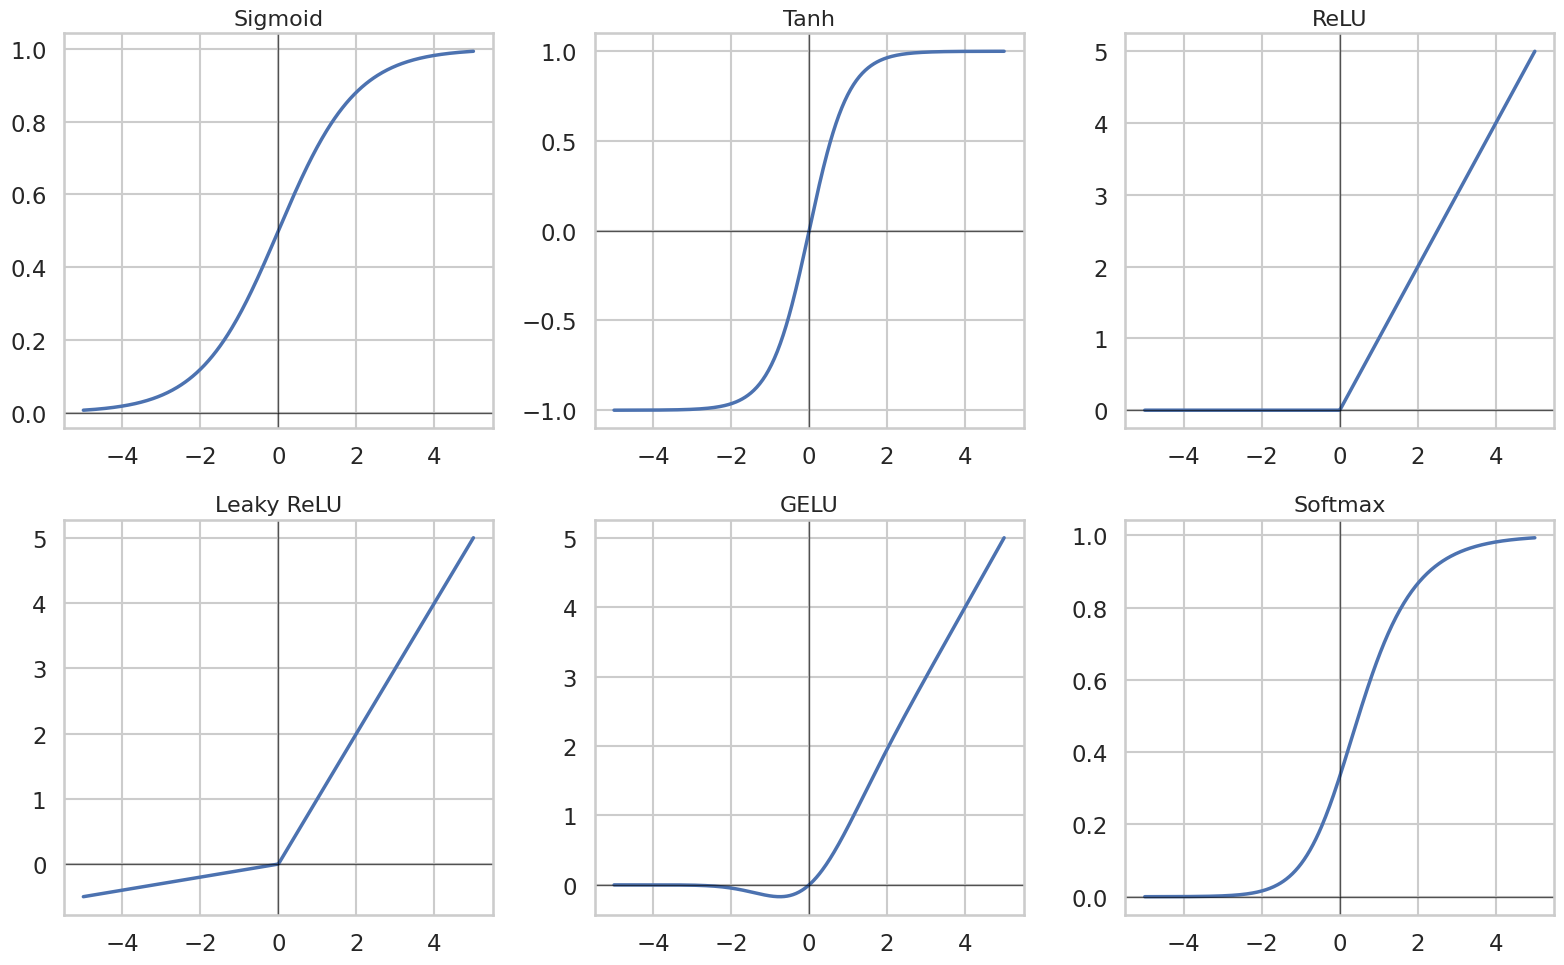

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")

x = torch.linspace(-5, 5, 400)

sigmoid = F.sigmoid(x)
tanh = F.tanh(x)
relu = F.relu(x)
leaky_relu = F.leaky_relu(x, negative_slope=0.1)
gelu = F.gelu(x)

vec = torch.stack([x, torch.zeros_like(x), -x], dim=1)  # [400, 3]
softmax_vals = F.softmax(vec, dim=1)[:, 0]

activations = {
    "Sigmoid": sigmoid.detach().numpy(),
    "Tanh": tanh.detach().numpy(),
    "ReLU": relu.detach().numpy(),
    "Leaky ReLU": leaky_relu.detach().numpy(),
    "GELU": gelu.detach().numpy(),
    "Softmax": softmax_vals.detach().numpy()
}

x_np = x.detach().numpy()

plt.figure(figsize=(16, 10))

for i, (name, y) in enumerate(activations.items(), 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=x_np, y=y, linewidth=2.5)
    plt.title(name, fontsize=16)
    plt.axhline(0, color="black", linewidth=1, alpha=0.6)
    plt.axvline(0, color="black", linewidth=1, alpha=0.6)

plt.tight_layout()
plt.show()

### Случайная инициализация

Давайте вспомним формулу линейного слоя:  

$$
y = Wx + b,
$$

где $W \in \mathbb{R}^{m \times n}$ - матрица весов.  
Именно её мы и инициализируем случайными числами.  

*Зачем это нужно?*

**1. Разрушить симметрию.**  
Если все веса задать одинаковыми (например, нулями), то все нейроны будут вычислять одно и то же, а их градиенты совпадут.  
Сеть станет «копией одного нейрона». Случайная инициализация ломает эту симметрию.  

**2. Сохранить масштаб сигналов.**  
Если веса слишком большие — выход $y$ «взорвётся», если слишком маленькие — сигнал затухнет.  
Хорошая инициализация подбирает диапазон случайных чисел так, чтобы значения оставались в рабочем масштабе.  

**3. Ускорить обучение.**  
Благодаря корректной инициализации оптимизация быстрее сходится, а сеть стабильнее обучается.  

#### Xavier и Kaiming

- **Xavier (Glorot) initialization**  
  Подбирает дисперсию весов так, чтобы средний масштаб входов и выходов совпадал.  
  Лучше всего работает с симметричными активациями вроде **tanh** или **sigmoid**.

- **Kaiming initialization**  
  Разработана специально для **ReLU**. Эта активация обнуляет отрицательные значения, уменьшая дисперсию сигнала.  
  Kaiming нормализует веса так, чтобы масштаб сохранялся и обучение не затухало.  

---

Итог: случайные веса - это не хаос, а продуманное начало, которое делает нейроны уникальными, сохраняет масштаб сигналов и ускоряет обучение.


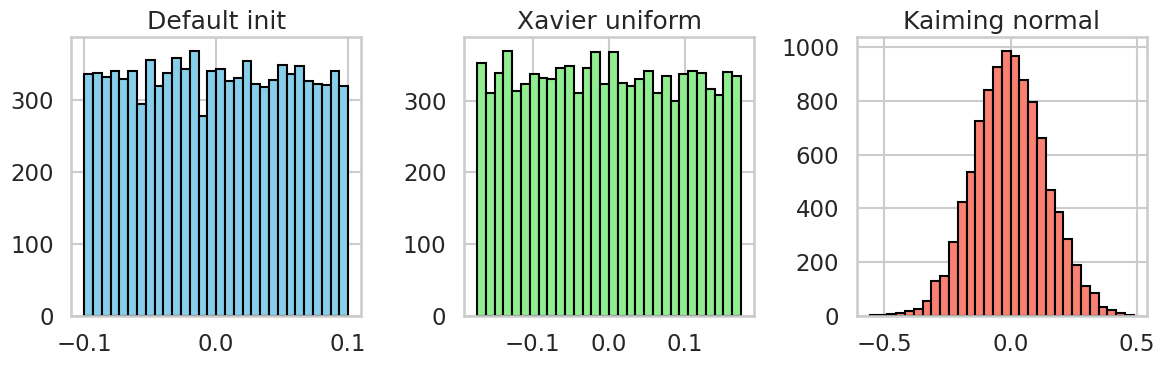

In [ ]:
layer = nn.Linear(100, 100, bias=False)

# 1. По умолчанию (uniform из [-1/sqrt(in), 1/sqrt(in)])
default_weights = layer.weight.detach().clone().view(-1).cpu().numpy()

# 2. Xavier uniform
nn.init.xavier_uniform_(layer.weight)
xavier_weights = layer.weight.detach().clone().view(-1).cpu().numpy()

# 3. Kaiming normal (под ReLU)
nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
kaiming_weights = layer.weight.detach().clone().view(-1).cpu().numpy()

# Визуализация
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.hist(default_weights, bins=30, color="skyblue", edgecolor="black")
plt.title("Default init")

plt.subplot(1,3,2)
plt.hist(xavier_weights, bins=30, color="lightgreen", edgecolor="black")
plt.title("Xavier uniform")

plt.subplot(1,3,3)
plt.hist(kaiming_weights, bins=30, color="salmon", edgecolor="black")
plt.title("Kaiming normal")

plt.tight_layout()
plt.show()


### Слой `Dropout`:

Dropout - это метод регуляризации нейронных сетей, который помогает снизить риск переобучения.

Во время обучения Dropout случайным образом зануляет выходные активации части нейронов с вероятностью $p$, уменьшая их вклад в дальнейшие вычисления.

**Формула Dropout:**

$$
y = \frac{1}{1-p} \cdot (x \odot m), \quad m \sim \text{Bernoulli}(1-p)
$$

где:

- $x$ - вектор активаций,
- $m$ - бинарная маска (0 или 1),
- $\odot$ - поэлементное умножение.

Масштабирование на $\frac{1}{1-p}$ необходимо для того, чтобы сохранить математическое ожидание активаций:

$$
\mathbb{E}[y] = \mathbb{E}[x].
$$

Иначе средний уровень сигнала на каждом слое изменялся бы в зависимости от вероятности зануления, что мешало бы обучению.

Dropout препятствует тому, чтобы сеть чрезмерно полагалась на отдельные связи, и способствует формированию более устойчивых признаков.

На этапе инференса зануление не выполняется - сеть использует все активации, уже отмасштабированные при обучении.

Интуиция:

– В ходе обучения часть нейронов "не даёт сигнал дальше".

– Это вынуждает соседние нейроны не полагаться только на конкретные связи, а искать более устойчивые комбинации признаков.

– На этапе инференса (test) ни один нейрон не зануляется - используется полная сеть, но с масштабированными весами/активациями.

In [ ]:
layer = nn.Dropout(p=0.5)
print(layer(torch.tensor([[1, 1, 1, 1]], dtype=torch.float)))

# На собеседованиях часто спрашивают, как работает Dropout и дают именно этот пример

tensor([[2., 0., 0., 2.]])


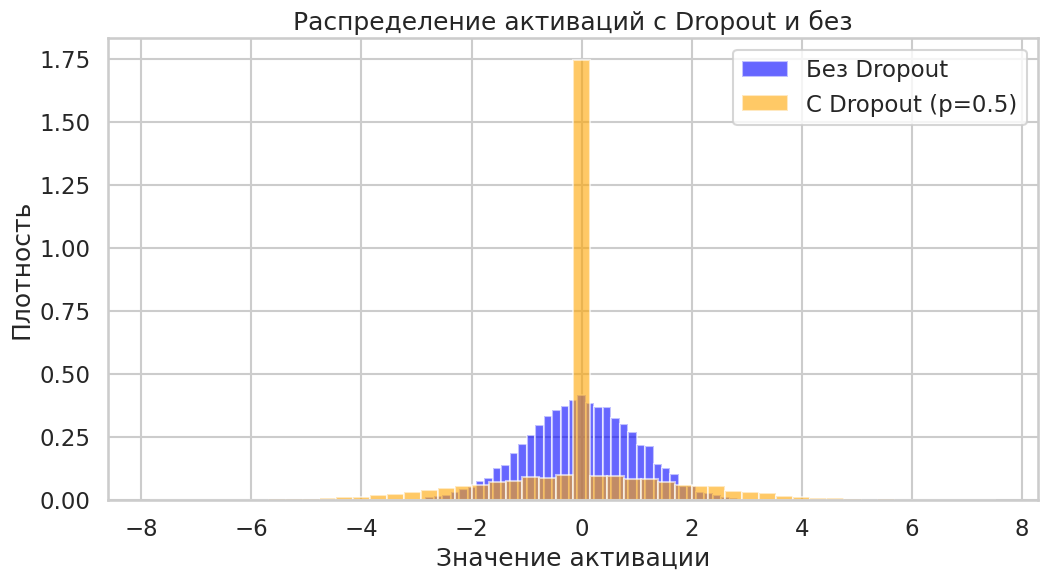

In [ ]:
# Генерируем случайные активации
x = torch.randn(10000)

# Dropout с p=0.5
dropout = nn.Dropout(p=0.5)
x_dropped = dropout(x)

# Перевод в numpy
x_np = x.detach().numpy()
x_dropped_np = x_dropped.detach().numpy()

# Построение графика
plt.figure(figsize=(12,6))
plt.hist(x_np, bins=50, alpha=0.6, label="Без Dropout", density=True, color="blue")
plt.hist(x_dropped_np, bins=50, alpha=0.6, label="С Dropout (p=0.5)", density=True, color="orange")

plt.title("Распределение активаций с Dropout и без", fontsize=18)
plt.xlabel("Значение активации")
plt.ylabel("Плотность")
plt.legend()
plt.show()

### [torch.optim](https://pytorch.org/docs/stable/optim.html)

In [ ]:
# Вспомогательный код для демонстрации оптимизаторов

simple_model = nn.ReLU(nn.Linear(10, 200))

#### **SGD**

> Не помешает повторить :)

Стохастический градиентный спуск обновляет параметры \(w\) по правилу:

$$
v_t = \mu v_{t-1} + \nabla L(w_t), \quad
w_{t+1} = w_t - \eta v_t,
$$

где $\eta$ - шаг обучения, $\mu$ - momentum.  

Оценка градиента по мини-батчу вносит шум, что помогает выходить из неглубоких минимумов, но требует аккуратного подбора $\eta$ и schedule.

Nesterov momentum экстраполирует шаг вперёд, сглаживая эту "пилу".  

Weight decay (L2) добавляет штраф $lambda \lVert w \rVert^2_2$, давая шаг:

$$
w \leftarrow w - \eta(\nabla L + \lambda w)
$$

**Плюсы:** простота, хорошее обобщение при верном тюнинге.  
**Минусы:** чувствителен к масштабу признаков и кривизне; может медленно сходиться по узким долинам.


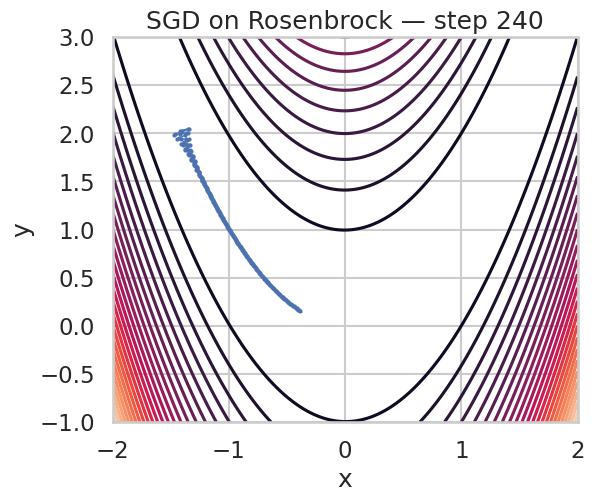

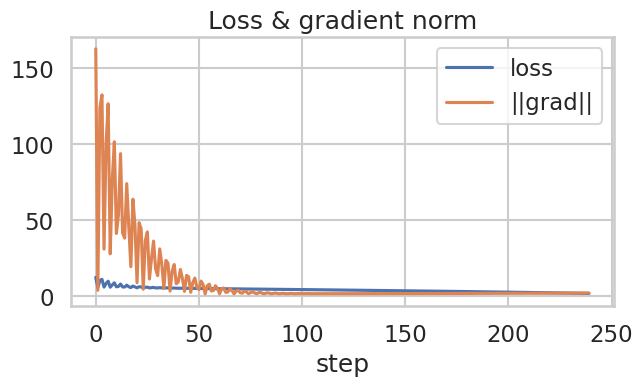

final w: [-0.3840166   0.15339324]


In [ ]:
opt_name = "sgd"         # "sgd" | "adam" | "lbfgs"
path, losses, gnorms, w_final = run_live_optim(
    opt_name=opt_name,
    steps=240,
    plot_every=20,
    start=(-1.5, 2.0),
    lr=5e-4, momentum=0.9        # для SGD; для Adam попробуй lr=2e-3; для LBFGS lr=1.0
)
print("final w:", w_final)


#### Adam

> Не помешает повторить :)

Adam объединяет momentum и адаптивный шаг по координатам (как RMSprop):

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t, \quad
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
$$

Смещения:

$$
\hat m_t = \frac{m_t}{1-\beta_1^t}, \quad
\hat v_t = \frac{v_t}{1-\beta_2^t}
$$

Обновление параметров:

$$
w_{t+1} = w_t - \eta \frac{\hat m_t}{\sqrt{\hat v_t} + \epsilon}
$$

**Плюсы:** быстрый прогресс, устойчив к масштабам градиента, почти без тюнинга.

**Минусы:** Медленнее SGD из-за того, что Adam хранит экспоненциальные скользящие средние для градиентов и их квадратов, что удваивает потребление памяти по сравнению с SGD. Также Adam делает дополнительные операции для обновления моментов делают каждый шаг медленнее.

Но щас Adam и AdamW являются базой в LLM и современном DL

In [ ]:
# Пример синтаксиса использования Adam, эту ячейку не запускаем
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

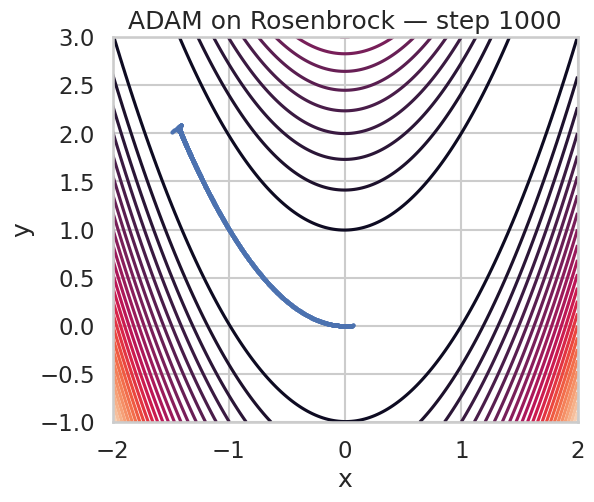

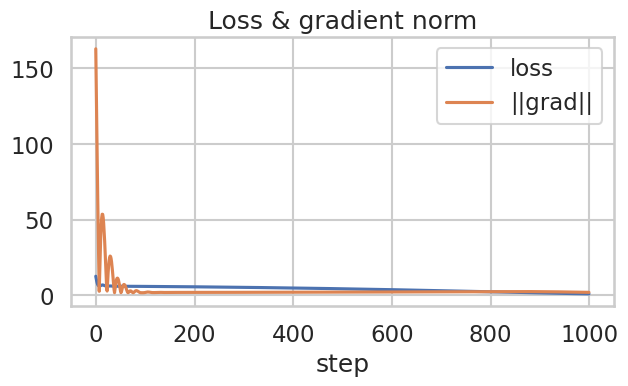

final w: [0.0673645  0.00395343]


In [ ]:
opt_name = "adam"         # "sgd" | "adam" | "lbfgs"
path, losses, gnorms, w_final = run_live_optim(
    opt_name=opt_name,
    steps=1000,
    plot_every=20,
    start=(-1.5, 2.0),
    lr=1e-2, momentum=0.1
)
print("final w:", w_final)


#### L-BFGS

L-BFGS - квази-Ньютоновский метод: строит приближение к $H_t^{-1}$ (обратному гессиану)  
по последним парам:

$$
s_t = w_t - w_{t-1}, \quad y_t = g_t - g_{t-1}
$$

через двухшаговую рекурсию. Направление:

$$
p_t = - H_t \nabla L(w_t)
$$

ищется линейным поиском (условия Вольф).  

**Плюсы:** быстрая сходимость на гладких задачах и полном батче, особенно для регрессии или дообучения последнего слоя.  
**Минусы:** тяжёл для огромных моделей и шумных мини-батчей; в PyTorch требует `closure` для пересчёта loss/grad.

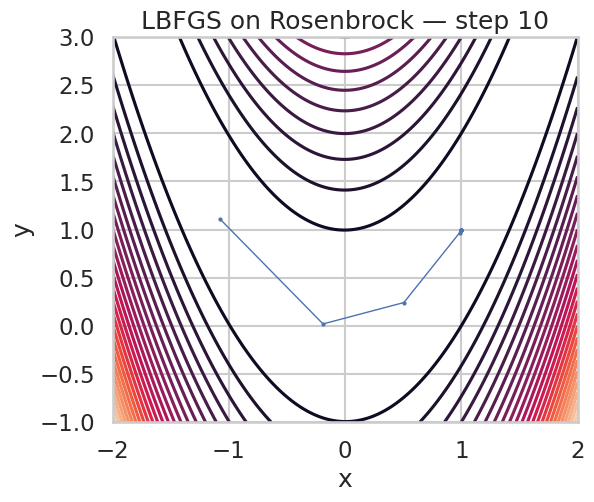

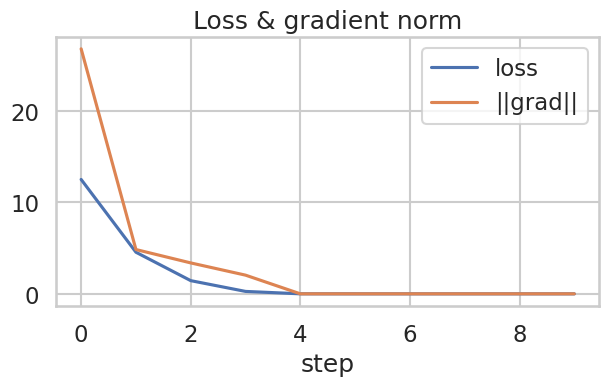

final w: [0.99998206 0.99996495]


In [ ]:
opt_name = "lbfgs"         # "sgd" | "adam" | "lbfgs"
path, losses, gnorms, w_final = run_live_optim(
    opt_name=opt_name,
    steps=10,
    plot_every=20,
    start=(-1.5, 2.0),
    lr=1, momentum=0.1
)
print("final w:", w_final)

**Собираем все вместе.** Теперь зная предыдущие шаги, мы можем поговорить про многослойный перцептрон.

### Многослойный перцептрон

MLP (Multi-Layer Perceptron, многослойный перцептрон) - это базовый тип нейронной сети, состоящий из нескольких слоев полносвязных (линейных) нейронов с нелинейными функциями активации между ними.

По сути, это композиция линейных преобразований и нелинейностей:

$$
y = f_L \big( W_L \, f_{L-1}(W_{L-1} \dots f_1(W_1 x + b_1) \dots ) + b_L \big)
$$

где:  

- $x$ - входной вектор признаков  
- $W_i, b_i$ - веса и смещения слоя  
- $f_i$ - функция активации (ReLU, Tanh, Sigmoid и т.п.)  


#### Пример MLP с одним скрытым слоем

$$
h = \mathrm{ReLU}(W_1 x + b_1), \quad y = W_2 h + b_2
$$

Давайте напишем этот пример на PyTorch.



In [ ]:
# Размерности: допустим, вход имеет 10 признаков, скрытый слой 5 нейронов, выход 3 класса
W1 = nn.Linear(10, 5)   # W1, b1
W2 = nn.Linear(5, 3)    # W2, b2

# Пример входного батча (batch=4, features=10)
x = torch.randn(4, 10)

# h = ReLU(W1 x + b1)
h = F.relu(W1(x))

# y = W2 h + b2
y = W2(h)

print("h shape:", h.shape)  # torch.Size([4, 5])
print("y shape:", y.shape)  # torch.Size([4, 3])

h shape: torch.Size([4, 5])
y shape: torch.Size([4, 3])


#### Регрессионные лоссы

Перед тем, как начать учить нашу первую регрессию, давайте поговорим про лоссы

В задачах регрессии лосс-функция измеряет разницу между предсказанием $\hat{y}$ и целевым значением $y$.

---

1. MSE (Mean Squared Error)

$
\mathcal{L}_{\text{MSE}} = \frac{1}{N}\sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$

Чувствителен к выбросам.

---

2. MAE (Mean Absolute Error)

$
\mathcal{L}_{\text{MAE}} = \frac{1}{N}\sum_{i=1}^{N} \lvert \hat{y}_i - y_i \rvert
$

Более устойчива к выбросам.

---

3. Huber Loss

$
\mathcal{L}_{\delta}(e) =
\begin{cases}
\frac{1}{2} e^2, & \text{если } |e| \leq \delta \\[6pt]
\delta \cdot (|e| - \tfrac{1}{2}\delta), & \text{если } |e| > \delta
\end{cases}
$

Где $e = \hat{y} - y$.

---

4. Smooth L1 Loss

$
\mathcal{L}(e) =
\begin{cases}
0.5 \cdot e^2, & |e| < 1 \\[6pt]
|e| - 0.5, & |e| \geq 1
\end{cases}
$

Часто используется в задачах компьютерного зрения (например, для обучения регрессии границ bounding box).

In [ ]:
y_pred = torch.rand([15, 2])
y_true = torch.rand([15, 2])

mse = nn.MSELoss()        # (y_pred - y_true)^2
mae = nn.L1Loss()         # |y_pred - y_true|
huber = nn.HuberLoss()    # гибрид MSE+MAE
smooth_l1 = nn.SmoothL1Loss()  # мягкая L1

# пример
loss = mse(y_pred, y_true)

#### MLP Регрессия

Чтобы реализовать собственную модель, нужно:

Создать класс, унаследованный от `nn.Module`.

В конструкторе `__init__` вызвать `super().__init__()` и объявить все слои.

Определить метод `forward()`, который описывает, как данные проходят через модель.

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden=64, depth=2, act=nn.Tanh):
        super().__init__()
        layers = [nn.Linear(1, hidden), act()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), act()]
        layers += [nn.Linear(hidden, 1)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

Сколько параметров в нашей моделе: 4353
MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


#### Генерация тестового примера

$$y = sin(x) + шум$$


In [ ]:
N = 512
x_min, x_max = -2*torch.pi, 2*torch.pi

x = np.linspace(x_min, x_max, N).astype(np.float32)
noise = np.random.normal(0.0, 0.05, size=N).astype(np.float32)  # можно поставить 0.0, чтобы без шума
y = np.sin(x) + noise

# train/val split
idx = np.arange(N)
np.random.shuffle(idx)
train_ratio = 0.8
n_train = int(train_ratio * N)
train_idx, val_idx = idx[:n_train], idx[n_train:]

x_train = torch.from_numpy(x[train_idx]).unsqueeze(1).to(device)
y_train = torch.from_numpy(y[train_idx]).unsqueeze(1).to(device)

x_val = torch.from_numpy(x[val_idx]).unsqueeze(1).to(device)
y_val = torch.from_numpy(y[val_idx]).unsqueeze(1).to(device)

x_all = torch.from_numpy(x).unsqueeze(1).to(device)
y_true_all = torch.from_numpy(np.sin(x).astype(np.float32)).unsqueeze(1).to(device)  # истинная синусоида без шума


Инициализируем модель, функцию потерь и оптимизатор

In [ ]:
model = MLP(hidden=64, depth=2, act=nn.Tanh).to(device)
print("Сколько параметров в нашей моделе:", sum(p.numel() for p in model.parameters()))
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

Сколько параметров в нашей моделе: 4353
MLP(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


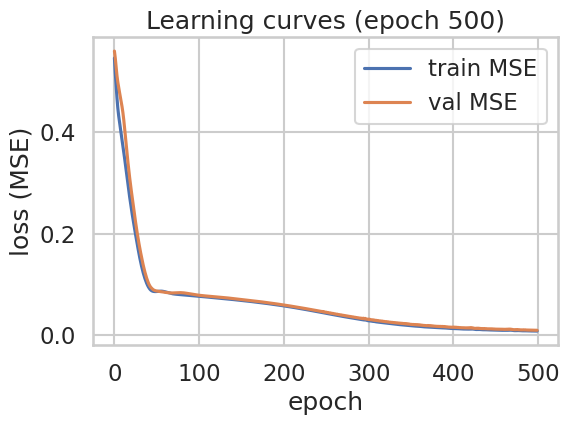

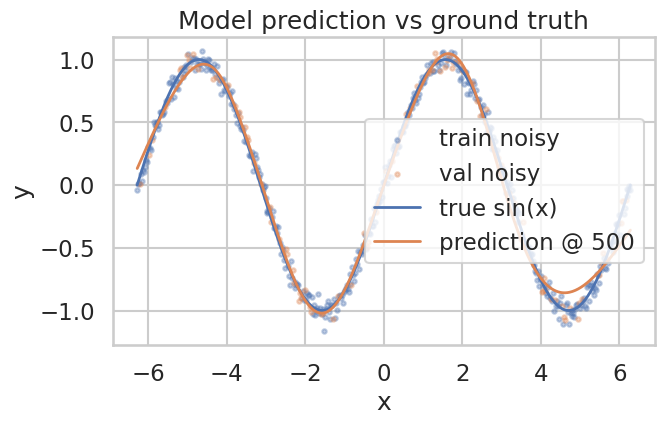

In [ ]:
epochs = 500
train_losses, val_losses = [], []

vis_every = 5  # как часто обновлять графику

for epoch in range(1, epochs+1):
    model.train()
    pred = model(x_train)
    loss = criterion(pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # val
    model.eval()
    with torch.no_grad():
        val_pred = model(x_val)
        val_loss = criterion(val_pred, y_val).item()

    train_losses.append(loss.item())
    val_losses.append(val_loss)

    if epoch % vis_every == 0 or epoch == 1 or epoch == epochs:
        print(f"Epoch {epoch:4d} | train {loss.item():.6f} | val {val_loss:.6f}")
        plot_live(epoch, model, x_train, y_train, x_val, y_val, x_all, y_true_all,
                  train_losses, val_losses)

    time.sleep(0.1)

#### Упражнение

Реализовать нейронку, которая решает многоклассовую задачу классификации

In [ ]:
# По аналогии с регрессионной моделью реализуйте и классификационную
# `n_outputs` - число выходных классов, именно столько должно быть выходов у модели

class ClassificationModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.logits = ...

    def forward(self, x):
        return self.logits(x)

In [ ]:
model = ClassificationModel(n_inputs=3, n_outputs=5)
print(model)

In [ ]:
inputs = torch.randn((16, 3))
outputs = model(inputs)

print("Inputs shape:", inputs.shape)
print("Outputs shape:", outputs.shape)

## Работа с данными

In [ ]:
import pandas as pd
import numpy as np

from sklearn.datasets import load_iris
from torch.utils.data import TensorDataset, random_split, DataLoader

Загрузим классический датасет ["Ирисы Фишера"](https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [ ]:
iris = load_iris()
X = torch.tensor(iris.data, dtype=torch.float32)      # фичи
y = torch.tensor(iris.target, dtype=torch.long)       # метки классов

Для того, чтобы удобно обучать нейросети с помощью PyTorch, в нем реализованы два класса работы с данными: `Dataset`, `DataLoader`.

In [ ]:
dataset = TensorDataset(X, y) #

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size

#### Упражнение

1. Создайте класс `MyDataset` - потомок класс Dataset.
2. Реализуйте метод `__getitem__`, который принимает индекс элемента и возвращает пару (x, y).
3. Реализуйте медов `__len__`, который возвращает размер датасета.

In [ ]:
from torch.utils.data import Dataset

In [ ]:
# Реализуйте необходимый класс

class MyDataset(Dataset):
    def __init__(self, X, y):
        # X — тензор признаков, y — тензор меток
        self.X = ...

    def __getitem__(self, idx):
        # возвращаем пару (x, y) по индексу
        return ...

    def __len__(self):
        # возвращаем количество элементов
        return ...

In [ ]:
my_dataset = MyDataset(X, y)

Посмотрим, что можно делать с датасетами. Мы можем получить его размер с помощью `len(...)`. Для этого мы реализовали метод `__len__`:

In [ ]:
print(len(my_dataset))

150


Мы также можем обращаться к массиву, используя различные виды индексирования:

In [ ]:
x, y = my_dataset[0]
print(x, y)

tensor([5.1000, 3.5000, 1.4000, 0.2000]) tensor(0)


In [ ]:
X_batch, y_batch = my_dataset[:5]
print(X_batch)
print(y_batch)

tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000],
        [5.0000, 3.6000, 1.4000, 0.2000]])
tensor([0, 0, 0, 0, 0])


In [ ]:
X_batch, y_batch = my_dataset[[0, 2, 5]]
print(X_batch)
print(y_batch)

tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [5.4000, 3.9000, 1.7000, 0.4000]])
tensor([0, 0, 0])


Класс `DataLoader` нужен для автоматического формирования батчей для заданного датасета.

In [ ]:
# Разделение
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# DataLoader-ы
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [ ]:
x_train, y_train = next(iter(train_loader))
print("x_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)

x_train.shape: torch.Size([16, 4])
y_train.shape: torch.Size([16])


## Обучение модели

In [ ]:
import random
import numpy as np
from tqdm import tqdm

Сделаем эксперименты воспроизводимыми.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Зададим параметры обучения.

In [ ]:
# Количество эпох (полных проходов по датасету)
n_epochs = 128

# Размерность входа
n_inputs = 4

# Размерность выхода (кол-во классов)
n_outputs = 3

# Скорость обучения (learning rate)
lr = 1e-3

Инициализируем модель, функцию потерь и оптимизатор.

In [ ]:
model = ClassificationModel(n_inputs=n_inputs, n_outputs=n_outputs)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Реализуем вычисление потерь на валидационном датасете.

In [ ]:
def compute_validation_loss(model, loader, loss_func):
    loss = 0
    # Используем нейросеть в режиме применения (отключаем Dropout, ...)
    model.eval()
    for x, y in loader:
        # Нам не нужно вычислять градиенты, поэтому можно сэкономить память
        with torch.no_grad():
            logits = model(x)
        loss += loss_func(logits, y).item() / len(loader)
    return loss

Реализуем цикл обучения нейросети (внешний цикл по эпохам, а внутренний -- по батчам). В конце каждой эпохи будем считать потери на валидационном датасете.

In [ ]:
train_losses = []
valid_losses = []

for epoch in range(1, n_epochs + 1):
    # обучение
    model.train() # Переводим модель в режим обучения (включаем Dropout, ...)
    batch_losses = []
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}", leave=False):
        logits = model(x)
        loss = loss_func(logits, y)
        optimizer.zero_grad() # Сбрасываем градиенты (.backward() только прибавляет новые градиенты к текущим)
        loss.backward() # Вычисляем градиенты
        optimizer.step() # Обновляем параметры нейросети
        batch_losses.append(loss.item())

    # средний train-loss
    train_loss = sum(batch_losses) / len(batch_losses)
    train_losses.append(train_loss)

    # валидация
    eval_loss = compute_validation_loss(model, valid_loader, loss_func) # Считаем потери на валидационном датасете
    valid_losses.append(eval_loss)

    tqdm.write(f"Epoch {epoch}: train_loss={train_loss:.4f}, valid_loss={eval_loss:.4f}")

    # график каждые 5 эпох
    if epoch % 5 == 0:
        plt.figure(figsize=(8,5))
        plt.plot(range(1, epoch+1), train_losses, label="Train Loss")
        plt.plot(range(1, epoch+1), valid_losses, label="Valid Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training / Validation Loss")
        plt.legend()
        plt.show()


## Выводы

**Железо и числовые форматы.** Для обучения DL-моделей нам критичны параллельные матричные операции. Именно поэтому используем GPU; для инференса крошечных моделей достаточно CPU. Рабочий формат - FP32, ускорение - mixed precision (FP16/BF16) там, где это стабильно.

**Фреймворки.** Несмотря на зоопарк библиотек: TensorFlow/JAX/Keras/PyTorch - мы в курсе делаем упор именно на PyTorch. Ведь там: динамический граф, простая отладка, сильная экосистема и продакшн-инструменты.

**Тензоры.** Мы глянули на базовые операции: создание, атрибуты (`shape/dtype/device`), broadcasting, различие `reshape` vs `permute` (форма ≠ порядок осей), перенос между CPU <-> GPU - за последним особенно тщательно следим.

**Autograd.** Вычислительный граф строится автоматически; `loss.backward()` считает градиенты, оптимизатор делает `step()`. Режимы: `model.train()` / `model.eval()` и `torch.no_grad()` для валидации/инференса.

**`torch.nn`.** Линейные слои, функции активации (ReLU/GELU/Sigmoid/Tanh/Softmax), регуляризация Dropout. Важна корректная инициализация, можно юзать Xavier/Kaiming.

**Оптимизация.** Посравнивали SGD (+momentum/Nesterov), Adam/AdamW, и L-BFGS: разные профили сходимости/стабильности/ресурсов. Выбираем наиболее оптимальный по ситуации.

**MLP.** Многослойный перцептрон - композиция `Linear + activation`. Выход и лосс зависят от задачи: регрессия - последний слой `Linear` без активации, `MSE/Huber`; многоклассовая классификация - `Linear` на `K` логитов, не делаем softmax в `forward`, `nn.CrossEntropyLoss` суммирует softmax+NLL; бинарная - один логит, `nn.BCEWithLogitsLoss`. Обосо следим за формами: вход `[batch, n_features]`, выход `[batch, n_outputs]`.


**Данные.** Абстракции **`Dataset`/`DataLoader`** - используем ее для батчинга, перемешивания и параллельной загрузки. Не забываем про важность логирования лоссов и базовой визуализации кривых обучения.



Главная мысль такая: **PyTorch = тензоры + autograd + модули + оптимизация**. Понимая эти четыре опоры, вы можете уверенно строить и тренировать как базовые MLP, так и современные большие модели.
